In [1]:
# Mengunduh dataset yang tersimpan di dalam Google Drive
# Dataset diunduh dari Kaggle (https://www.kaggle.com/bappekim/air-pollution-in-seoul)
!gdown --id 1Wkq4nlpXoO0cSugGm18kD7ch-HCFpLDR

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Wkq4nlpXoO0cSugGm18kD7ch-HCFpLDR
To: /content/Dataset Submission 2.zip
100% 6.97M/6.97M [00:00<00:00, 144MB/s]


In [2]:
# Mengekstrak file .zip
import zipfile
import os
local_zip = '/content/Dataset Submission 2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [3]:
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
original_dataset = pd.read_csv('/content/Measurement_summary.csv')
original_dataset.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [5]:
locations = original_dataset['Address']
print("Number of unique locations: ", len(locations.unique()))
print(locations.value_counts())

Number of unique locations:  25
71, Gangseo-ro 45da-gil, Gangseo-gu, Seoul, Republic of Korea        25906
369, Yongmasan-ro, Jungnang-gu, Seoul, Republic of Korea             25906
19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea            25905
17, Sanggye-ro 23-gil, Nowon-gu, Seoul, Republic of Korea            25905
236, Baekjegobun-ro, Songpa-gu, Seoul, Republic of Korea             25905
16, Sinbanpo-ro 15-gil, Seocho-gu, Seoul, Republic of Korea          25905
10, Poeun-ro 6-gil, Mapo-gu, Seoul, Republic of Korea                25905
14, Sillimdong-gil, Gwanak-gu, Seoul, Republic of Korea              25905
70, Samyang-ro 2-gil, Seongbuk-gu, Seoul, Republic of Korea          25905
15, Deoksugung-gil, Jung-gu, Seoul, Republic of Korea                25905
426, Hakdong-ro, Gangnam-gu, Seoul, Republic of Korea                25904
20, Geumha-ro 21-gil, Geumcheon-gu, Seoul, Republic of Korea         25904
56, Jungang-ro 52-gil, Yangcheon-gu, Seoul, Republic of Korea       

In [6]:
# Distrik Yangcheon-gu dipilih karena memiliki kepadatan penduduk tertinggi
# di antara distrik lainnya (berdasarkan https://en.wikipedia.org/wiki/List_of_districts_of_Seoul)
dataset = original_dataset.loc[original_dataset['Address'] == '56, Jungang-ro 52-gil, Yangcheon-gu, Seoul, Republic of Korea']
dataset = dataset[['Measurement date', 'CO']]
dataset['Measurement date'] = pd.to_datetime(dataset['Measurement date'])
dataset.rename(columns={'Measurement date': 'Date'}, inplace=True)

In [7]:
print("Missing values:\n", dataset.isnull().sum(), sep='')
print("\nDataset length: ", len(dataset))
dataset

Missing values:
Date    0
CO      0
dtype: int64

Dataset length:  25904


,Date,CO
362594,2017-01-01 00:00:00,1.3
362595,2017-01-01 01:00:00,1.3
362596,2017-01-01 02:00:00,1.2
362597,2017-01-01 03:00:00,1.3
362598,2017-01-01 04:00:00,1.1
...,...,...
388493,2019-12-31 19:00:00,0.5
388494,2019-12-31 20:00:00,0.5
388495,2019-12-31 21:00:00,0.5
388496,2019-12-31 22:00:00,0.5


Text(0, 0.5, 'CO Level')

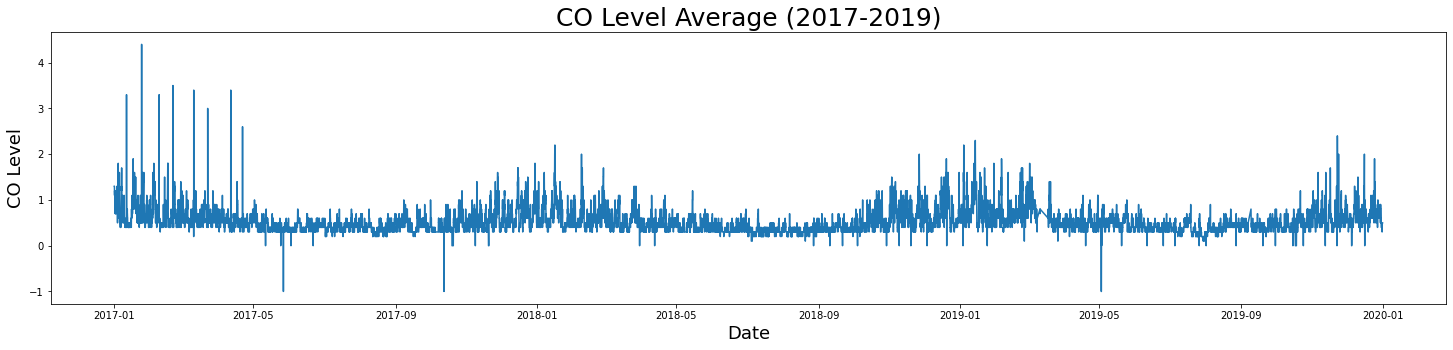

In [8]:
date = dataset['Date'].values
co = dataset['CO'].values

plt.figure(figsize=(25, 5))
plt.plot(date, co)
plt.title('CO Level Average (2017-2019)', fontsize=25);
plt.xlabel('Date', fontsize=18)
plt.ylabel('CO Level', fontsize=18)

In [9]:
# Dataset splitting
split = round(0.8*len(date))

train_date = date[:split]
test_date = date[split:]

train_co = co[:split]
test_co = co[split:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
data_scale = max(co)-min(co)
print("MAE must be below", 0.1*data_scale)
scaler = MinMaxScaler()

MAE must be below 0.54


In [11]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(train_co, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(test_co, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(1),
])

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mae') < 0.1) and (logs.get('val_mae') < 0.1):
            print("\nDesired MAE value (0.1) reached.")
            self.model.stop_training = True

callbacks = myCallback()

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=100,
    shuffle=False,
    callbacks=[callbacks]
)

Epoch 1/100
647/647 [==============================] - 16s 12ms/step - loss: 0.0383 - mae: 0.1812 - val_loss: 0.0185 - val_mae: 0.1509
Epoch 2/100
647/647 [==============================] - 7s 10ms/step - loss: 0.0197 - mae: 0.1374 - val_loss: 0.0154 - val_mae: 0.1337
Epoch 3/100
647/647 [==============================] - 7s 10ms/step - loss: 0.0174 - mae: 0.1274 - val_loss: 0.0129 - val_mae: 0.1177
Epoch 4/100
647/647 [==============================] - 7s 10ms/step - loss: 0.0156 - mae: 0.1194 - val_loss: 0.0114 - val_mae: 0.1070
Epoch 5/100
647/647 [==============================] - 7s 10ms/step - loss: 0.0144 - mae: 0.1127 - val_loss: 0.0102 - val_mae: 0.0961
Epoch 6/100
647/647 [==============================] - 7s 11ms/step - loss: 0.0138 - mae: 0.1103 - val_loss: 0.0099 - val_mae: 0.0934
Epoch 7/100
647/647 [==============================] - 7s 10ms/step - loss: 0.0135 - mae: 0.1090 - val_loss: 0.0097 - val_mae: 0.0909
Epoch 8/100
647/647 [==============================] - 7s 10m

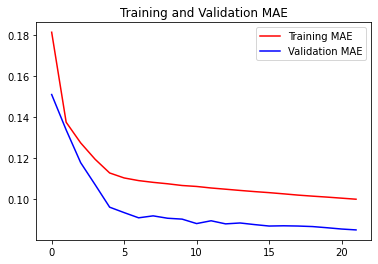

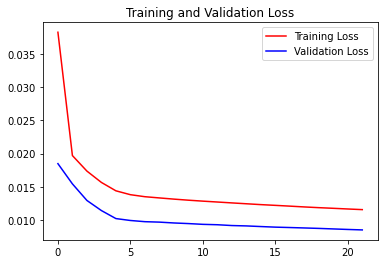

In [16]:
# Membuat plot loss dan akurasi pada proses latihan dan validasi
%matplotlib inline
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()